In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import sys
import copy
from tqdm.notebook import tqdm
from numba import jit
from scipy import stats
import networkx as nx
import re

import matplotlib.lines as mlines
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-deep')
plt.rcParams["text.usetex"] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amssymb,amsmath}'

plt.rcParams["figure.figsize"] = 11.7, 8.3
plt.rcParams["figure.dpi"] = 75

plt.rcParams["font.size"] = 28
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Fira Sans", 'PT Sans', 'Open Sans', 'Roboto', 'DejaVu Sans', 'Liberation Sans', 'sans-serif']

plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.fontsize"] = "small"

plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams["lines.markersize"] = 14
plt.rcParams["lines.markeredgewidth"] = 2

plt.rcParams["xtick.major.size"] = 8
plt.rcParams["ytick.major.size"] = 8


In [2]:
import math

def generate_S1_model(beta, n, gamma, mean_degree=10):
    assert beta > 1, "Beta should be larger than 1"
    
    kappa_0 = (
        (1 - 1 / n)
        / (1 - n ** ((2 - gamma) / (gamma - 1)))
        * (gamma - 2)
        / (gamma - 1)
        * mean_degree
    )
    base = 1 - 1 / n
    power = 1 / (1 - gamma)
    kappas = {i: kappa_0 * (1 - np.random.rand() * base) ** power for i in range(n)}

    G = nx.Graph()
    R = n / (2 * math.pi)

    # Approximate values for mu in the thermodynamic limit (when n -> infinity)
    mu = beta * math.sin(math.pi / beta) / (2 * math.pi * mean_degree)
    
    # Generate random positions on a circle
    thetas = {k: np.random.uniform(0, 2 * math.pi) for k in kappas}

    for u in kappas:
        for v in list(G):
            angle = math.pi - math.fabs(math.pi - math.fabs(thetas[u] - thetas[v]))
            dij = math.pow(R * angle, beta)
            mu_kappas = math.pow(mu * kappas[u] * kappas[v], max(1, beta))
            p_ij = 1 / (1 + dij / mu_kappas)

            # Create an edge with a certain connection probability
            if np.random.rand() < p_ij:
                G.add_edge(u, v)
        G.add_node(u)

    nx.set_node_attributes(G, thetas, "theta")
    nx.set_node_attributes(G, kappas, "kappa")

    # Map hidden degrees into the radial coordiantes
    zeta = 1 if beta > 1 else 1 / beta
    kappa_0 = min(list(kappas.values()))
    R_c = 2 * max(1, beta) / (beta * zeta)
    R_hat = (2 / zeta) * math.log(n / math.pi) - R_c * math.log(mu * kappa_0**2)
    radii = {
        node: R_hat - R_c * math.log(kappa / kappa_0) for node, kappa in kappas.items()
    }
    nx.set_node_attributes(G, radii, "radius")

    return G

In [3]:
from sklearn.metrics import accuracy_score

def generate_random_positions(N):
    return np.random.uniform(0, 2*np.pi, size=N)


def angle(t1, t2):
    return np.pi - np.fabs(np.pi - np.fabs(t1 - t2))


def assign_labels(thetas, centers, alpha):
    labels = []
    for t in thetas:
        total_distance = sum([np.power(angle(t, c), -alpha) for c in centers]) 
        prob = [np.power(angle(t, c), -alpha) / total_distance for c in centers]
        l = np.random.choice(len(prob), size=1, p=prob)[0]
        labels.append(l)
    return labels

In [4]:
def generate_graph_with_labels(beta, n, gamma, nlabels, alpha):
    g = generate_S1_model(beta, n, gamma)
    thetas = list(nx.get_node_attributes(g, 'theta').values())
    centers = generate_random_positions(nlabels)
    labels = assign_labels(thetas, centers, alpha)
    nx.set_node_attributes(g, {d: l for d,l in zip(list(g.nodes()), labels)}, 'label')
    return g

In [5]:
def compute_homophily(g):
    H = 0
    for u in g.nodes():
        label = g.nodes[u]['label']
        h = 0
        neighbours = list(g.neighbors(u))
        for n in neighbours:
            if g.nodes[n]['label'] == label:
                h += 1
                
        if len(neighbours) > 0:
            h /= len(neighbours)
        
        H += h
    H /= len(g)
    return H

In [43]:
n = 1000
betas = [1.1, 3.0]
gammas = [2.1, 3.5]
nlabels = [2, 3, 6, 10]
alphas = np.arange(-10, 11)

ntimes = 100

results = {}

for b in betas:
    for gamma in tqdm(gammas):
        for nlabel in nlabels:
            for a in tqdm(alphas):
                res = []
                for i in range(ntimes):
                    g = generate_graph_with_labels(b, n, gamma, nlabel, a)
                    res.append(compute_homophily(g))
                
                results[(b, gamma, nlabel, a)] = res
                    

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [44]:
df = pd.DataFrame(results)

df = df.T.reset_index()
cols = [f'i{i}' for i in range(ntimes)]
df.columns = ['beta', 'gamma', 'nlabels', 'alpha', *cols]
df

,beta,gamma,nlabels,alpha,i0,i1,i2,i3,i4,i5,...,i90,i91,i92,i93,i94,i95,i96,i97,i98,i99
0,1.1,2.1,2,-10,0.709443,0.692859,0.708052,0.697165,0.704729,0.718890,...,0.702206,0.723910,0.730706,0.705848,0.699672,0.716346,0.723893,0.680633,0.719357,0.723138
1,1.1,2.1,2,-9,0.730080,0.745639,0.689757,0.734846,0.679073,0.720992,...,0.495541,0.711720,0.501771,0.719087,0.709504,0.716842,0.555619,0.687321,0.686847,0.725826
2,1.1,2.1,2,-8,0.717279,0.650208,0.703249,0.688533,0.588084,0.683719,...,0.532969,0.687410,0.647656,0.562558,0.677545,0.717147,0.493142,0.410062,0.728884,0.688980
3,1.1,2.1,2,-7,0.697322,0.568596,0.699094,0.713780,0.708452,0.681032,...,0.708607,0.720546,0.705080,0.717729,0.494639,0.656287,0.678108,0.690283,0.711687,0.728864
4,1.1,2.1,2,-6,0.737302,0.687518,0.463486,0.711753,0.520747,0.644589,...,0.687293,0.540019,0.626003,0.453063,0.711751,0.675195,0.664013,0.602113,0.430205,0.729314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,3.0,3.5,10,6,0.807676,0.809703,0.783899,0.849964,0.806016,0.682859,...,0.832841,0.852496,0.875749,0.702674,0.788150,0.719541,0.859808,0.676188,0.767429,0.796642
332,3.0,3.5,10,7,0.849479,0.784621,0.734244,0.807211,0.854783,0.875408,...,0.860598,0.884863,0.832088,0.776399,0.880189,0.690497,0.877797,0.870299,0.886431,0.884503
333,3.0,3.5,10,8,0.883472,0.884382,0.887612,0.802194,0.848441,0.880334,...,0.827677,0.878916,0.868136,0.893420,0.849178,0.830241,0.817689,0.870932,0.885777,0.889202
334,3.0,3.5,10,9,0.781819,0.756027,0.853877,0.897846,0.872732,0.895020,...,0.894212,0.909908,0.896781,0.887323,0.874431,0.909996,0.881902,0.897832,0.859679,0.886236


In [108]:
def plot_results(df_tmp, color, label):
    x = df_tmp['alpha']
    y_mean = np.mean([df_tmp[i] for i in cols], axis=0)
    y_std = np.std([df_tmp[i] for i in cols], axis=0)
    plt.plot(x, y_mean, color=color, label=label)
    plt.fill_between(x, y_mean+y_std, y_mean-y_std, color=color, alpha=0.2)
    plt.xlabel(r'$\alpha$')
    plt.ylabel('Homophily')
    
def plot_per_nlabel(df, nlabel):
    colors = ['xkcd:orange', 'xkcd:royal blue', 'xkcd:moss green', 'xkcd:purple', 'xkcd:violet']
    i = 0
    for b in betas:
        for gamma in gammas:
            tmp = df[df['beta'] == b][df['gamma'] == gamma][df['nlabels'] == nlabel]
            plot_results(tmp, colors[i], fr'$\beta={{{b}}},\gamma={{{gamma}}}$')
            
            # TODO: the limit of homophily for the random should be 1/N_L
            plt.axhline(1/nlabel, color='black', linestyle='--', linewidth=2)
            plt.text(7, 1/nlabel+0.02, rf'$1/{{{nlabel}}}$', fontsize=14)
            i += 1
            
    plt.ylim(0.02, 1.01)
    plt.yticks([0.1, 0.5, 1.0])

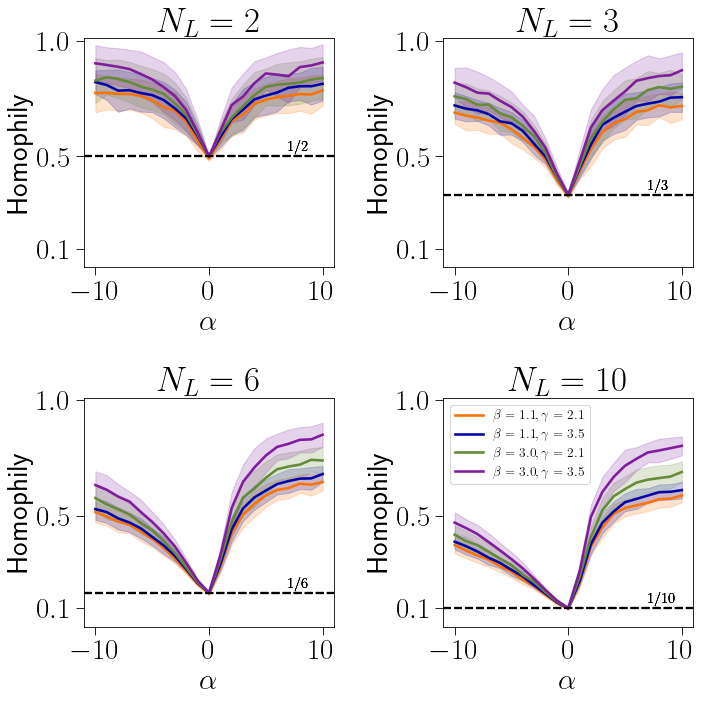

In [109]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plot_per_nlabel(df, 2)
plt.title(r'$N_L=2$')

plt.subplot(2, 2, 2)
plot_per_nlabel(df, 3)
plt.title(r'$N_L=3$')

plt.subplot(2, 2, 3)
plot_per_nlabel(df, 6)
plt.title(r'$N_L=6$')

plt.subplot(2, 2, 4)
plot_per_nlabel(df, 10)
plt.title(r'$N_L=10$')
plt.legend(fontsize=13)

plt.tight_layout()